In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import pickle as pkl
from scipy import stats
import random 
import time

In [4]:
import utility_funcs as uf

### The following Hurst function was taken in part from <a href = "https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing">here</a>

In [5]:
def hurst(p):
    '''
    Description:
        Given an iterable (p), this functions calculates the Hurst exponent
        by sampling from the linear space
    Inputs:
        p: an iterable
    Outputs:
        the Hurst exponent
    '''
    # find variances for different sets of price differences:
    p = np.array(p)
    tau = np.arange(2,100)
    variancetau = [np.var(np.subtract(p[lag:], p[:-lag])) for lag in tau]

    # find the slope of the fitting line in the log-log plane:
    tau = np.log(tau)
    variancetau = np.log(variancetau)
    # find and remove mean:
    xb = np.mean(tau)
    yb = np.mean(variancetau)
    tau -= xb
    variancetau -= yb
    # find the slope:
    m = np.dot(tau, variancetau) / np.dot(tau, tau)

    return m / 2

In [6]:
def add_cur_name(df,cur_name):
    df["cur_name"] = cur_name
    print(cur_name,"done!")

def remove_old_days(df,yr='2018'):
    cond = df.Date > yr+"-01-01"
    df = df[cond].copy()
    return df
def func_collection(df,cur_name,yr="2018"):
    df = remove_old_days(df,yr)
    add_cur_name(df,cur_name)
    
    return df

In [7]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [8]:
def rnd_walk_simulator(sigma = 1, candle_bundle = 100, num_bundles = 200, initial = 1,\
                       generator = 'normal', seed = None):
    '''
    Description:
        Generates random-walks of various size, and puts them in a pandas dataframe, in a column
        named 'close'
    Inputs:
        sigma: the scale to be used for each step
        candle_bundle: the number of samples to bundle together
        num_bundles: the total random-walk length
        initial: the initial value to use, first element of the random-walk
    '''
    df = pd.DataFrame()
    close_var = initial     
    close_list = []
    np.random.seed(seed)
    for x in range(num_bundles):
        tick_data = []
        if generator == 'normal':
            rnd = np.random.normal(loc=0.0, scale=sigma, size = candle_bundle)
            close_var += np.sum(rnd)
        elif generator == 'uniform':
            rnd = np.random.uniform(low=0, high= 1, size = candle_bundle)
            close_var += np.sum((rnd - 0.5)*sigma)
        elif generator == 'poisson':
            rnd = np.random.poisson(lam = 1, size = candle_bundle)
            close_var += np.sum((rnd - 1)*sigma)
                     
        close_list.append(close_var)     
        
    df["close"] = close_list
    
    return df

In [11]:
file_list = glob.glob("./data/*")
file_dict = {f:f.split("/")[-1][:-4] for f in file_list}
        
print(file_list)

['./data/NZD_CHF.csv', './data/GBP_USD.csv']


In [12]:
df = uf.read_many_files(file_list,add_to_each_df_func=lambda df,x: func_collection(df,x,yr="2017"),\
                        func_args=file_dict)

df = df.dropna(axis = 0)
df.head()

NZD_CHF done!
GBP_USD done!


,Date,open,high,low,close,volume,cur_name
742846,2017-01-02 23:00:00,0.70944,0.70962,0.70895,0.70912,444,NZD_CHF
742847,2017-01-02 23:02:00,0.70914,0.70952,0.70896,0.70906,208,NZD_CHF
742848,2017-01-02 23:04:00,0.70904,0.70914,0.70892,0.70902,87,NZD_CHF
742849,2017-01-02 23:06:00,0.70902,0.70948,0.70900,0.70941,65,NZD_CHF
742850,2017-01-02 23:08:00,0.70950,0.70952,0.70934,0.70938,31,NZD_CHF


0.4919592117920463


Text(0.5,0,'Example A')

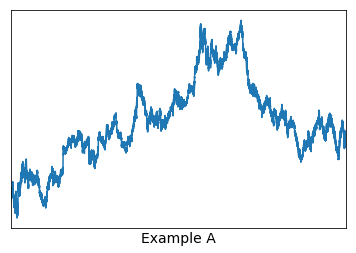

In [13]:
cond = df.cur_name == "GBP_USD"
print(hurst(df[cond].close ))
df[cond].close.plot()

frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_visible(False)
plt.xlabel('Example A',fontsize = 14)

0.466222952573976


Text(0.5,0,'Example B')

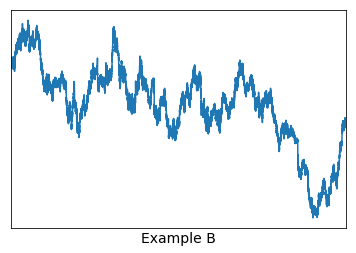

In [14]:
cond = df.cur_name == "NZD_CHF"
print(hurst(df[cond].close))
df[cond].close.plot()

frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_visible(False)
plt.xlabel('Example B',fontsize = 14)

0.49815925500399966


Text(0.5,0,'Example C')

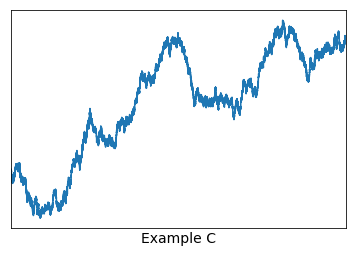

In [15]:
df_rnd1 = rnd_walk_simulator(seed=10, sigma= 0.00005, num_bundles=300000)
print(hurst(df_rnd1.close))
df_rnd1.close.plot()

frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_visible(False)
plt.xlabel('Example C',fontsize = 14)

0.49433492766978543


Text(0.5,0,'Example D')

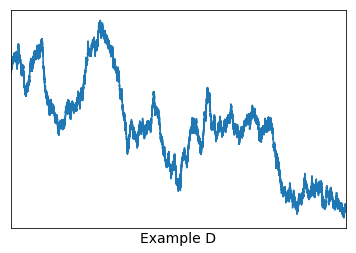

In [16]:
df_rnd2 = rnd_walk_simulator(seed=100, sigma= 0.00005, num_bundles=300000)
print(hurst(df_rnd2.close))
df_rnd2.close.plot()

frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_visible(False)
plt.xlabel('Example D',fontsize = 14)

# Hurst exponent for Forex market:
### For a nice post on Hurst exponent and its indications look at <a href = "http://epchan.blogspot.com/2016/04/mean-reversion-momentum-and-volatility.html">here</a>.

## all data:

In [17]:
for pair in df.cur_name.unique():
    cond = df.cur_name == pair
    hs = hurst(df[cond].close)
    print("Hurst for %s is %.5f"%(pair,hs),end = ' , ')
    print("total len of the df is:",len(df[cond]))

Hurst for NZD_CHF is 0.46622 , total len of the df is: 347646
Hurst for GBP_USD is 0.49196 , total len of the df is: 343709


# Random Walks:

### rnd_steps = 10000:

### normal:

In [17]:
hurst_li10n = []
st = time.time()
for ii in range(10000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 candle_bundle=1,\
                                 num_bundles = 10000,\
                                 seed = ii,\
                                 generator='normal')
    
    hs = hurst(df_norm.close.values)
    hurst_li10n.append(hs)
    if ii%500 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()


0 done, time= 0.0962, 500 done, time= 34.9130, 1000 done, time= 33.4250, 1500 done, time= 33.4468, 2000 done, time= 33.3330, 2500 done, time= 33.3497, 3000 done, time= 33.4137, 3500 done, time= 33.3155, 4000 done, time= 33.4977, 4500 done, time= 33.4594, 5000 done, time= 33.7591, 5500 done, time= 33.3843, 6000 done, time= 33.4233, 6500 done, time= 33.3005, 7000 done, time= 33.3244, 7500 done, time= 34.0827, 8000 done, time= 33.7646, 8500 done, time= 34.2802, 9000 done, time= 33.2515, 9500 done, time= 33.5301, 

In [18]:
pkl.dump(hurst_li10n,open("./hurst_li10_n.pkl","wb"))

0.4973285518801711 0.019287160134145304


(0.41, 0.58)

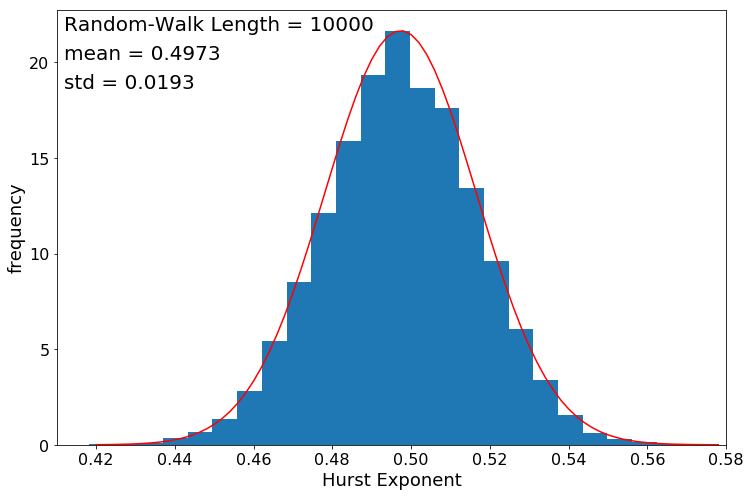

In [86]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li10n),np.std(hurst_li10n) )
a = plt.hist(hurst_li10n,bins=30,normed=True)

x_range = np.arange(0.42,0.58,0.002)
amp = np.max(a[0])
plt.plot(x_range, amp*gaussian(x_range,np.mean(hurst_li10n),np.std(hurst_li10n)),'r')

plt.text(0.412,amp,"Random-Walk Length = 10000",fontsize = 20)
plt.text(0.412,amp-1.5,"mean = "+'{0:.4f}'.format(np.mean(hurst_li10n)),fontsize = 20)
plt.text(0.412,amp-3,"std = "+'{0:.4f}'.format(np.std(hurst_li10n)),fontsize = 20)
plt.xlabel("Hurst Exponent",fontsize=18)
plt.ylabel("frequency",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.41,0.58)

### uniform:

In [21]:
hurst_li10u = []
st = time.time()
for ii in range(10000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 candle_bundle=1,\
                                 num_bundles = 10000,\
                                 seed = ii,\
                                 generator='uniform')
    
    hs = hurst(df_norm.close.values)
    hurst_li10u.append(hs)
    if ii%500 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()

0 done, time= 0.1095, 500 done, time= 42.9416, 1000 done, time= 43.0851, 1500 done, time= 39.1965, 2000 done, time= 39.0544, 2500 done, time= 39.1885, 3000 done, time= 38.9128, 3500 done, time= 38.9099, 4000 done, time= 38.9808, 4500 done, time= 38.8322, 5000 done, time= 39.4153, 5500 done, time= 38.7849, 6000 done, time= 38.5917, 6500 done, time= 38.7031, 7000 done, time= 38.5378, 7500 done, time= 38.5613, 8000 done, time= 38.5767, 8500 done, time= 38.5169, 9000 done, time= 38.4373, 9500 done, time= 38.6781, 

In [22]:
pkl.dump(hurst_li10u,open("./hurst_li10_u.pkl","wb"))

0.4975865490974271 0.01920499738172972


(0.41, 0.58)

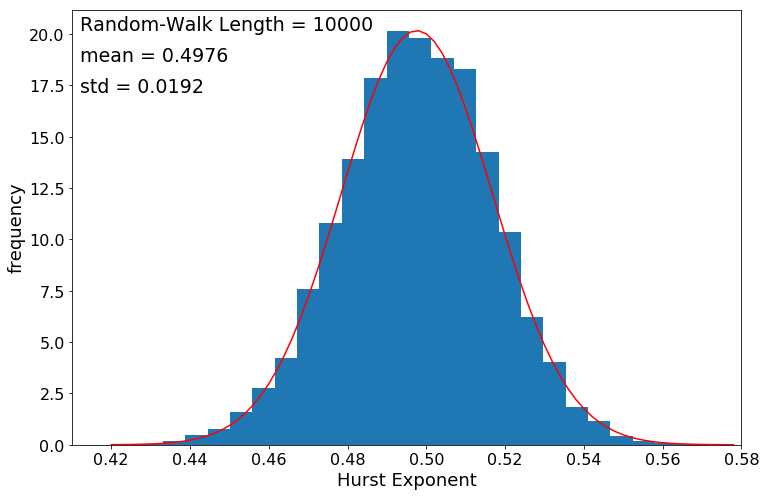

In [87]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li10u),np.std(hurst_li10u) )
a = plt.hist(hurst_li10u,bins=25,normed=True)

x_range = np.arange(0.42,0.58,0.002)
amp = np.max(a[0])
plt.plot(x_range, amp*gaussian(x_range,np.mean(hurst_li10u),np.std(hurst_li10u)),'r')

plt.text(0.412,amp,"Random-Walk Length = 10000",fontsize = 19)
plt.text(0.412,amp-1.5,"mean = "+'{0:.4f}'.format(np.mean(hurst_li10u)),fontsize = 19)
plt.text(0.412,amp-3,"std = "+'{0:.4f}'.format(np.std(hurst_li10u)),fontsize = 19)
plt.xlabel("Hurst Exponent",fontsize=18)
plt.ylabel("frequency",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.41,0.58)

### Poisson:

In [25]:
hurst_li10p = []
st = time.time()
for ii in range(10000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 candle_bundle=1,\
                                 num_bundles = 10000,\
                                 seed = ii,\
                                 generator='poisson')
    
    hs = hurst(df_norm.close.values)
    hurst_li10p.append(hs)
    if ii%500 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()

0 done, time= 0.1370, 500 done, time= 42.1722, 1000 done, time= 43.8220, 1500 done, time= 42.4492, 2000 done, time= 42.4437, 2500 done, time= 42.3429, 3000 done, time= 43.9027, 3500 done, time= 42.2558, 4000 done, time= 42.3798, 4500 done, time= 42.1131, 5000 done, time= 42.0931, 5500 done, time= 42.0448, 6000 done, time= 42.1390, 6500 done, time= 42.2498, 7000 done, time= 42.1194, 7500 done, time= 42.1572, 8000 done, time= 42.3313, 8500 done, time= 42.5118, 9000 done, time= 42.0514, 9500 done, time= 42.1852, 

In [26]:
pkl.dump(hurst_li10p,open("./hurst_li10_p.pkl","wb"))

0.49761077945781906 0.019397083706689088


(0.41, 0.58)

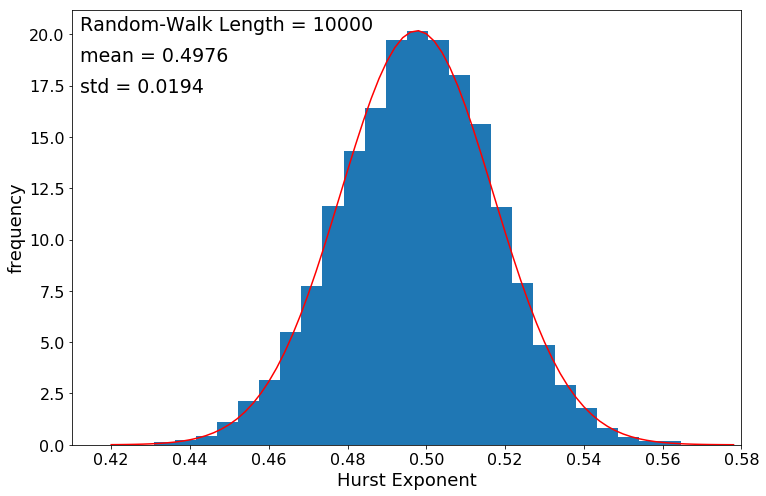

In [88]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li10p),np.std(hurst_li10p) )
a = plt.hist(hurst_li10p,bins=25,normed=True)

x_range = np.arange(0.42,0.58,0.002)
amp = np.max(a[0])
plt.plot(x_range, amp*gaussian(x_range,np.mean(hurst_li10p),np.std(hurst_li10p)),'r')

plt.text(0.412,amp,"Random-Walk Length = 10000",fontsize = 19)
plt.text(0.412,amp-1.5,"mean = "+'{0:.4f}'.format(np.mean(hurst_li10p)),fontsize = 19)
plt.text(0.412,amp-3,"std = "+'{0:.4f}'.format(np.std(hurst_li10p)),fontsize = 19)
plt.xlabel("Hurst Exponent",fontsize=18)
plt.ylabel("frequency",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.41,0.58)

### rnd_steps = 100000:

### normal:

In [35]:
hurst_li100 = []
st = time.time()
for ii in range(10000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 candle_bundle=1,\
                                 num_bundles = 100000,\
                                 seed = ii,\
                                 generator='normal')
    
    hs = hurst(df_norm.close.values)
    hurst_li100.append(hs)
    if ii%500 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()

0 done, time= 0.6589, 500 done, time= 360.5264, 1000 done, time= 369.0569, 1500 done, time= 381.9417, 2000 done, time= 375.6941, 2500 done, time= 352.2228, 3000 done, time= 360.5117, 3500 done, time= 377.1919, 4000 done, time= 382.5946, 4500 done, time= 347.6013, 5000 done, time= 344.6007, 5500 done, time= 346.9138, 6000 done, time= 352.7429, 6500 done, time= 353.7730, 7000 done, time= 350.1097, 7500 done, time= 351.7248, 8000 done, time= 348.2312, 8500 done, time= 349.3438, 9000 done, time= 350.8850, 9500 done, time= 351.5927, 

In [62]:
hurst_li100 = pkl.load(open("./hurst_li100.pkl","rb"))

0.4996890151279655 0.0060831918456582465


(0.475, 0.525)

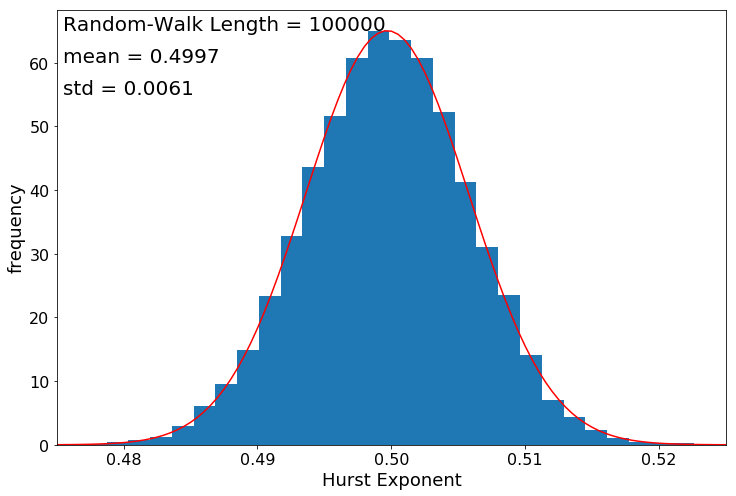

In [91]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li100),np.std(hurst_li100) )
a = plt.hist(hurst_li100,bins=30,normed=True)

x_range = np.arange(0.47,0.53,0.0005)
amp = np.max(a[0])
plt.plot(x_range, amp*gaussian(x_range,np.mean(hurst_li100),np.std(hurst_li100)),'r')

plt.text(0.4755,amp,"Random-Walk Length = 100000",fontsize = 20)
plt.text(0.4755,amp-5,"mean = "+'{0:.4f}'.format(np.mean(hurst_li100)),fontsize = 20)
plt.text(0.4755,amp-10,"std = "+'{0:.4f}'.format(np.std(hurst_li100)),fontsize = 20)
plt.xlabel("Hurst Exponent",fontsize=18)
plt.ylabel("frequency",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.475,0.525)

In [54]:
print(stats.skew(hurst_li100))
print(stats.kurtosis(hurst_li100))

-0.023029401278034163
0.0022576095483266556


In [57]:
pkl.dump(hurst_li100,open("./hurst_li100.pkl","wb"))

### uniform:

In [58]:
hurst_li100u = []
st = time.time()
for ii in range(10000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 candle_bundle=1,\
                                 num_bundles = 100000,\
                                 seed = ii,\
                                 generator='uniform')
    
    hs = hurst(df_norm.close.values)
    hurst_li100u.append(hs)
    if ii%500 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()

0 done, time= 0.7648, 500 done, time= 3415.9947, 1000 done, time= 367.2228, 1500 done, time= 366.4329, 2000 done, time= 367.1245, 2500 done, time= 368.8297, 3000 done, time= 370.5546, 3500 done, time= 369.9341, 4000 done, time= 371.6526, 4500 done, time= 416.5966, 5000 done, time= 465.9186, 5500 done, time= 436.6161, 6000 done, time= 445.7589, 6500 done, time= 445.5698, 7000 done, time= 443.8797, 7500 done, time= 425.7276, 8000 done, time= 427.9445, 8500 done, time= 419.9981, 9000 done, time= 388.9699, 9500 done, time= 384.5860, 

0.49970485614083465 0.006022231078746345


(0.475, 0.525)

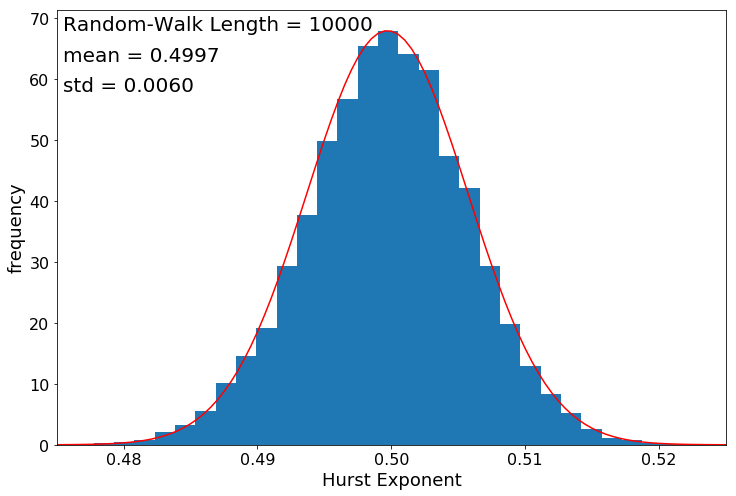

In [90]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li100u),np.std(hurst_li100u) )
a = plt.hist(hurst_li100u,bins=30,normed=True)

x_range = np.arange(0.47,0.53,0.0005)
amp = np.max(a[0])
plt.plot(x_range, amp*gaussian(x_range,np.mean(hurst_li100u),np.std(hurst_li100u)),'r')

plt.text(0.4755,amp,"Random-Walk Length = 10000",fontsize = 20)
plt.text(0.4755,amp-5,"mean = "+'{0:.4f}'.format(np.mean(hurst_li100u)),fontsize = 20)
plt.text(0.4755,amp-10,"std = "+'{0:.4f}'.format(np.std(hurst_li100u)),fontsize = 20)
plt.xlabel("Hurst Exponent",fontsize=18)
plt.ylabel("frequency",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.475,0.525)

In [61]:
pkl.dump(hurst_li100u,open("./hurst_li100u.pkl","wb"))

###  rnd_steps = 300000:

In [86]:
hurst_li300 = []
st = time.time()
for ii in range(1000):
    df_norm = rnd_walk_simulator(sigma =  0.002,\
                                 num_bundles = 300000,\
                                 seed = ii)
    
    hs = hurst(df_norm.close.values)
    hurst_li300.append(hs)
    if ii%100 == 0:
        print("%d done, time= %.4f"%(ii,time.time()-st),end=", ")
        st = time.time()

0 done, time= 3.3026, 100 done, time= 363.5886, 200 done, time= 370.8800, 300 done, time= 344.2197, 400 done, time= 349.9841, 500 done, time= 354.0914, 600 done, time= 339.4433, 700 done, time= 325.0656, 800 done, time= 344.1690, 900 done, time= 332.2664, 

0.4996838765361534 0.003520648542656769


(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text yticklabel objects>)

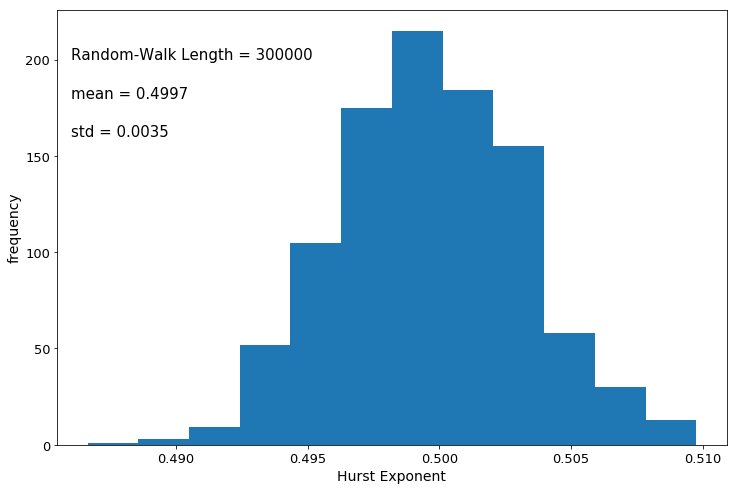

In [39]:
plt.figure(figsize=(12,8))
print(np.mean(hurst_li300),np.std(hurst_li300) )
_ = plt.hist(hurst_li300,bins=12)

plt.text(0.486,200,"Random-Walk Length = 300000",fontsize = 15)
plt.text(0.486,180,"mean = "+'{0:.4f}'.format(np.mean(hurst_li300)),fontsize = 15)
plt.text(0.486,160,"std = "+'{0:.4f}'.format(np.std(hurst_li300)),fontsize = 15)
plt.xlabel("Hurst Exponent",fontsize=14)
plt.ylabel("frequency",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)